# Deep Learning and Text
Challenge: [Santander Rio y MetaData](https://metadata.fundacionsadosky.org.ar/competition/21/)


## Connect to google and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from tqdm.notebook import trange, tqdm
import os

In [3]:
import torch
if torch.cuda.is_available():
  torch.device('cuda')

In [4]:
from torch import nn

### Gather Data

In [5]:
# %%capture output
!unzip -o 'drive/My Drive/Colab Notebooks/nlp-sadosky/data.zip' -d ./

Archive:  drive/My Drive/Colab Notebooks/nlp-sadosky/data.zip
   creating: ./data/
   creating: ./data/raw/
  inflating: ./data/raw/test_santander.csv  
  inflating: ./data/raw/train.csv    
  inflating: ./data/raw/first_submit_santander.csv  
  inflating: ./data/raw/.gitkeep     
   creating: ./data/external/
  inflating: ./data/external/answers.csv  
  inflating: ./data/external/CREA_total.zip  
  inflating: ./data/external/.gitkeep  
  inflating: ./data/external/stopwords.txt  
  inflating: ./data/external/CREA_total.TXT  
  inflating: ./data/external/dict.json  
   creating: ./data/processed/
  inflating: ./data/processed/.gitkeep  
  inflating: ./data/processed/test_cleaned.csv  
  inflating: ./data/processed/train_cleaned.csv  
   creating: ./data/interim/
  inflating: ./data/interim/.gitkeep  
  inflating: ./data/interim/dictionary.gz  
   creating: ./data/results/
   creating: ./data/.ipynb_checkpoints/


In [6]:
DATA_DIR ='./data'
RAW_DIR =  os.path.join(DATA_DIR, 'raw/')
PROCESSED_DIR =  os.path.join(DATA_DIR, 'processed/')
EXTERNAL_DIR = os.path.join(DATA_DIR, 'external/')
TRAIN_DATA = os.path.join(PROCESSED_DIR, 'train_cleaned.csv')
TEST_DATA = os.path.join(PROCESSED_DIR, 'test_cleaned.csv')
STOPWORDS_DIR = os.path.join(EXTERNAL_DIR, 'stopwords.txt')

## Features



### Explore dataset
If you explore the ./data/raw/... folder you will see 2 new files: 
- train.csv
- test_santander.csv


In [7]:
# pregunta:
# categoria:

columns = ["Pregunta", "Intencion"]

In [8]:
!ls $TRAIN_DATA

./data/processed/train_cleaned.csv


In [9]:
data = pd.read_csv(TRAIN_DATA, encoding='utf-8', sep=',')

# data.columns = columns
data.sample(5)

,Pregunta,Intencion
2508,no puedo darme de baja de la sorpresa,Cat_320
13332,que quiere decir este movimiento?,Cat_115
12214,desear baja debito automatico tarjeta credito ...,Cat_345
815,donde puedo obtener una dijo?,Cat_67
4230,la cuenta infinity gold es con chequera?,Cat_39


In [10]:
test = pd.read_csv(TEST_DATA)
test


,id,Pregunta
0,0,querer saber tarjeta sin limite
1,1,¿cuál es el límite de mi tarjeta santander?
2,2,hay beneficios en restaurantes de la costa atl...
3,3,semana realizar pagar afip monotributo volver ...
4,4,por un prestamo de mil cuanto es el interes?
...,...,...
6697,6697,denunciar un cobro de tarjeta de credito
6698,6698,quiero pagar deuda refinanciada
6699,6699,quiero pagar de mi open credit un poquito mas ...
6700,6700,nesecito imprimir mi resumen tarjeta de credit...


In [11]:
# test.Pregunta.str.len().argmax()
# s = test.Pregunta.apply(cleaner.sentence_cleaning)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20104 entries, 0 to 20103
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pregunta   20104 non-null  object
 1   Intencion  20104 non-null  object
dtypes: object(2)
memory usage: 314.2+ KB


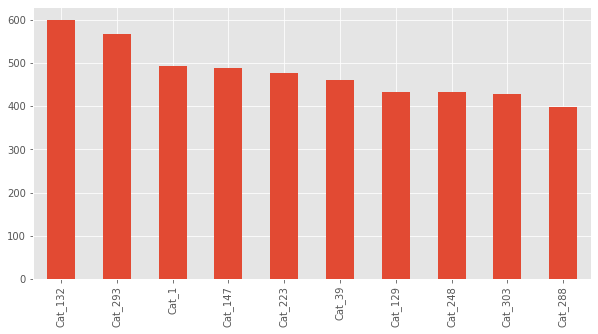

In [13]:
data.loc[:,'Intencion'].value_counts()[0:10].plot.bar(figsize=(10,5))
plt.show()

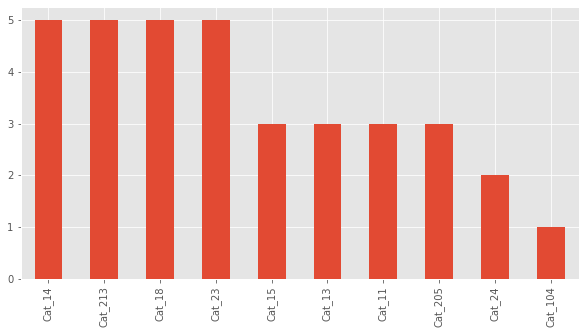

In [14]:
data.loc[:,'Intencion'].value_counts()[-10:].plot.bar(figsize=(10,5))
plt.show()

In [15]:
data.loc[:,'Intencion'].nunique()

352

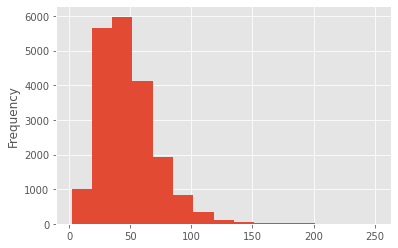

In [16]:
# size of words
data.Pregunta.str.len().plot.hist(bins=15)

In [17]:
# data['Intencion'] = data['Intencion'].str.replace('Cat_','').astype('int').astype('category')
# data['Intencion'], data["Intencion"].cat.codes
# data["Target"] = data['Intencion'].cat.codes.astype('int')

In [18]:
# para adaptar al código existente
data["Target"] = data.Intencion

In [19]:
# dictcats = { code: cat for code, cat in zip(data.Target, data.Intencion)}
# print(dictcats)

### Data Cleaning

In [20]:
# import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer , TreebankWordTokenizer
import re
from toolz import pipe
from functools import partial
import string
import tokenize

In [21]:
def get_stopwords():
  STOPWORDS = set(stopwords.words('spanish'))
  STOPWORDS.discard('no') #this souldn't be an stopword
  return STOPWORDS

def get_specialwords():
  """
  Clean known spelling mistakes
  """
  return [
          ('\\bccredito\\b|\\bcredit\\b','credito'),('pra','para'),('\\bx\\b','por'),('\\bq\\b','que'),
          ('\\bxq\\b','porque'),('\\bcta\\b|\\bctas\\b','cuenta'),('targeta','tarjeta'),('nececit|nesecit','necesit'),
          ('queiro','quiero'),('\\b0kilometro\\b|\\b0k\\b|\\b0kmm\\b','0km'),
          ('\\baadavantatge\\b|\\baadnatage_\\b|\\baadvantag\\b|\\baadvantege\\b|\\baddvantage\\b|\\baadvantagee\\b','aadvantage'),('aaños','años'),
          ('aberes','haberes'),('abiles','habiles'),('aceder|acseder|adceder|accederv','acceder'),('acuenta','a cuenta'),
          ('acumuladasi','acumuladas'),('adentanto','adelanto'),('aderente','adherente'),('aderirme|adhirirme','adherirme'),
          ('adhesioni','adhesion'),
          ('balkin|balking|bamking|bankie|bankig|bankin|banquin|banquing|bancking|baking|bangking|bankingg','banking'),
          ('bco|bsnco|baco','banco'),('benficio','beneficio'),('boucher','voucher'),('brazil|buzios','brasil')
          ] + [
          ('aciento','asiento'),('ahroa','ahora'),('american express','amex'),('atravez|atraves','a traves'),
          ('balenco','banelco'),('baucher|boucher','voucher'),('canselacion','cancelacion'),('cartele|cartelito','cartel'),
          ('cobroon','cobro'),('comprovante','comprobante'),('comunicaciin','comunicacion'),('consuitar|consultala','consultar'),
          ('contactacme','contactar'),('datos','dato'),
          ('darian|\\bdarla\\b|\\bdarlas\\b|\\bdarle\\b|\\bdarlo\\b|\\bdarte\\b|\\bdas\\b','dar'),
          ('devite|devito','debito'),('dirjo|dirijio','dirigirme'),('\\bdolar\\b|dolars','dolares')
          ]

In [22]:
class Cleaner():
  """
  This class executes regexes for cleaning the dataset.
  - filter stopwords
  - clean mispellings
  - remove tokens and punctuation (string.punctuation)
  """  

  def __init__(self):
    nltk.download('punkt')
    nltk.download('stopwords')

    self.STOPWORDS = get_stopwords()
    self.SPECIALWORDS=get_specialwords()

    self.tk = TreebankWordTokenizer()
    self.dtk = TreebankWordDetokenizer()
    # self.SPACES=re.compile("\s+")
    self.BAD_CAT_REMOVE = re.compile('^Cat_')
    self.A_TILDE_REMOVE = re.compile('[á]')
    self.E_TILDE_REMOVE = re.compile('[é]')
    self.I_TILDE_REMOVE = re.compile('[í]')
    self.O_TILDE_REMOVE = re.compile('[ó]')
    self.U_TILDE_REMOVE = re.compile('[ú]')
    self.POINT_FOLLOWING_LETTER=re.compile('(?<=\S)(\.|\,)(?=\w)') # once or zero space following ". or ," following  once or zero alphanumeric
    self.WEIRD = re.compile("[" + "|".join("¬≠¬≠¬≠¬≠¬≠¬≠‚ç¨≈°¬¨¬†‚äö¬¨√ö¬°¬¨äö¬¨√ö¬æ¬¢‚äö¬¨√ö¬°¬¨‚ç¨¬¶¬°¬¨¬≠¬≠‚ç¨≈°¬¨¬¶‚äö¬¨√ö¬°¬¨‚ç¨¬¶‚äö¬¨√ö".split())+"]") #fix special case
    self.specials_regex = [re.compile(bad) for bad, _ in self.SPECIALWORDS] # generate spelling corrector with regex.
    self.correct_words = [ correct for _, correct in self.SPECIALWORDS]
    self.BAD_SYMBOLS_REMOVE = re.compile('[^A-Za-z0-9_ áéíóú]')
  
  def applyRegex(self, value,regex,replacement):
    value = regex.sub(replacement,value)
    return value

  def text_cleaning(self, text):
 
    return pipe(
        text.lower(),
        partial(self.BAD_SYMBOLS_REMOVE.sub,  ''), 
        partial(self.WEIRD.sub, ''), 
        # partial(self.SPACES.sub, ''), 
        partial(self.A_TILDE_REMOVE.sub, 'a'), 
        partial(self.E_TILDE_REMOVE.sub, 'e'), 
        partial(self.I_TILDE_REMOVE.sub, 'i'), 
        partial(self.O_TILDE_REMOVE.sub, 'o'), 
        partial(self.U_TILDE_REMOVE.sub, 'u'), 
        *(partial(regex.sub, correct) for regex, correct in zip(self.specials_regex, self.correct_words)),
        # partial(self.POINT_FOLLOWING_LETTER.sub('. '))
    )

  def sentence_cleaning(self, sentence, detokenize=False):
    word_tokens = pipe(
        sentence, 
        # partial(self.POINT_FOLLOWING_LETTER.sub, '. '),
        self.tk.tokenize
    )       

    
    word_tokens = [word.strip(string.punctuation+"¿¡") for word in word_tokens]

    word_tokens = [self.text_cleaning(text) for text in word_tokens if not text in self.STOPWORDS and text not in string.whitespace]

    if detokenize:
        return self.dtk.detokenize(word_tokens)
    else: 
        return word_tokens
        

In [25]:
def replace_unknown(r):
    return cleaner.sentence_cleaning(r, detokenize=True)

def tqdemizado(s, pbar):
    pbar.update(1)
    return replace_unknown(s)

cleaner = Cleaner()
pbar = tqdm(total=len(data.Pregunta))
data["Pregunta"] = data.Pregunta.apply(lambda s: tqdemizado(s, pbar))

pbar.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
# see mean and std lenght of sentences, to fix as a default lenght to feed the NN
data.Pregunta.str.len().mean(), data.Pregunta.str.len().std(), data.Pregunta.str.len().max(), data.Pregunta.str.len().min()

(35.96264424990052, 16.137940288041, 178, 2)

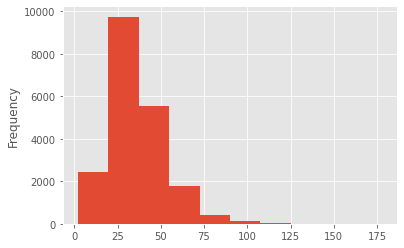

In [27]:
# data[data.Pregunta.str.len() > 128].sort_values(by="Pregunta") # to found sentences longer than 128 characters
# data.iloc[9314].Pregunta # special case, misspelling
data.Pregunta.str.len().plot.hist()

### DataIngestion with Dataset and Example's
To feed the model we will use Torchtext.
- Define a LabelField
- Define a TextField with fixed lenght at 64 characters

In [28]:
%%capture output
!pip install -U torchtext==0.6.0
import torchtext

In [394]:
## Defining fields for the model
LABEL = torchtext.data.LabelField()
TWEET = torchtext.data.Field(tokenize='spacy', lower=True, eos_token="<eos>", fix_length=64)

In [395]:
fields = [
  ('Target', LABEL), 
  ('Pregunta', TWEET),
]

In [396]:
# we define 3 categories types regarding cardinality, we test three options, and we detect that with less data it is less accurate than we have more data.
categories = data.Target.value_counts()[(data.Target.value_counts()>2)].index
categories_low = data.Target.value_counts()[(data.Target.value_counts()<100) & (data.Target.value_counts()>2)].index
categories_high = data.Target.value_counts()[(data.Target.value_counts()>=80)].index

In [397]:
from sklearn.model_selection import train_test_split

data_trainable = data[data.Target.isin(categories_high)]

data_train, data_test = train_test_split(data_trainable, train_size=0.1, stratify=data_trainable.Target, shuffle=True, random_state=42)
data_valid, data_test = train_test_split(data_test, stratify=data_test.Target, train_size=0.1, shuffle=True)

In [398]:
data_train

,Pregunta,Intencion,Target,Predicted
8929,quiero abrir caja ahorro no cbu como puedo hac...,Cat_39,Cat_39,Cat_39
7713,querer cerrar cuenta,Cat_41,Cat_41,Cat_41
16916,ao caja ahorrar convenio universia casar cerra...,Cat_61,Cat_61,Cat_61
6449,funciona compara protegida american express,Cat_311,Cat_311,Cat_311
9893,servicio mantenimiento paga meses,Cat_96,Cat_96,Cat_96
...,...,...,...,...
17528,numero superlinda,Cat_147,Cat_147,Cat_147
13636,quisiera ver cuanto margen tarjeta,Cat_303,Cat_303,Cat_303
18921,solicito tarjeta,Cat_337,Cat_337,Cat_337
10886,no emitido aun no resumenes cuenta tarjetas cr...,Cat_138,Cat_138,Cat_138


In [399]:
def map_examples(data):
  examples=[]
  for ex in tqdm(data[['Target', 'Pregunta']].values):
    examples.append(torchtext.data.Example.fromlist(ex, fields))
  return examples


In [400]:
examples_train = map_examples(data_train)
examples_valid = map_examples(data_valid)
examples_test = map_examples(data_test)

In [401]:
# pytorch need a dataset to feed de nn
train = torchtext.data.Dataset(examples_train, fields)
test = torchtext.data.Dataset(examples_test, fields)
valid = torchtext.data.Dataset(examples_valid, fields)


In [402]:
# Build a vocabulary
%%timeit
vocab_size = 20000
TWEET.build_vocab(train, max_size = vocab_size)
LABEL.build_vocab(train)

100 loops, best of 3: 6.99 ms per loop


In [403]:
# this is a kind of DataLoader.
train_iterator, valid_iterator, test_iterator = torchtext.data.BucketIterator.splits(
  (train, valid, test), 
  batch_size = 256, 
  device = 'cuda',
  shuffle=True,
  sort_key = lambda x: len(x.Pregunta),
  sort_within_batch = False
)

In [404]:
len(TWEET.vocab), len(LABEL.vocab)

(1233, 53)

## Training

### Defining a model

The iterator returns shape => (sequence_len, batch_size)
Embedding Layer:
- input ( * )
- output (*, embedding_size)

So embedding returns shape => (seq_len, batch_size, embedding_size)

Then, a RNN expects:
- Input (seq_len, batch_size, input_size)

- output: output, (h_n, c_n)
  - output: (seq_len, batch, num_directions * hidden_size)
  - h_n: (num_layers * num_directions, batch, hidden_size)
  - c_n:(num_layers * num_directions, batch, hidden_size) (only LSTM)
> If it is bidireccional, multiply num_direcctions * hidden_size by 2.

To sum up, in RNN layers:
- input_size should be embedding_dim.
- we should use hidden[-1,:,:] or 
  - hidden[-1,:,:] and hidden[-1,:,:] if it is bidirectional: 
  ```torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)```
  - ```assert torch.equal(output[-1,:,:], hidden.squeeze(0))``` should be true



Ver https://towardsdatascience.com/understand-how-to-use-namedtuple-and-dataclass-in-python-e82e535c3691

Este mixin is our Trainer. as pytorch-lighting 

In [405]:
class TrainerMixin():
  def training_step(self, batch, loss_fn, metric):
    inputs, labels = batch 
    out = self(inputs) # Generate predictions call forward method
    loss = loss_fn(out, labels) # Calculate loss
    acc = metric(out, labels)
    return {'train_loss': loss, 'train_acc': acc}
    
  def validation_step(self, batch, loss_fn, metric):
    inputs, labels = batch 
    out = self(inputs)          # Generate predictions call forward method
    loss = loss_fn(out, labels) # Calculate loss
    acc = metric(out, labels)   # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    #TODO: refactor
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def train_epoch_end(self, outputs):
    #TODO: refactor
    batch_losses = [x['train_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

    batch_accs = [x['train_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

    return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result,lrs):
    last_lr = "Last LR: {:.7f}".format(lrs['last_lr'])
    if (lrs['last_lr'] != lrs['lr']): last_lr="Update LR. From: {:.7f} to: {:.7f}".format(lrs['last_lr'], lrs['lr'])
    
    print("Epoch [{}] || val_loss: {:.4f}, val_acc: {:.4f} || train_loss : {:.4f}, train_acc: {:.4f} || {}".format(
        epoch, 
        result['val_loss'], 
        result['val_acc'],
        result['train_loss'], 
        result['train_acc'],
        last_lr
        )
    )
    print("*"*25)


We need "balanced_accuracy", so we must refactor "accuracy" metric.
[See this](https://www.kaggle.com/jonathanloscalzo/pytorch-text-classification-torchtext-lstm/edit)

In [406]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# TODO
# def balanced_accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def fit(epochs, model, train_iterator, val_loader, optimizer, loss_fn, scheduler=None, early_stopping=15):
  history = []
  stopping_counter = 0
  best_metric = np.inf
  best_model=model.state_dict()

  for epoch in range(1,epochs+1):
    # Training Phase 
    model.train()
    train_epoch = []
    last_lr = optimizer.param_groups[0]['lr']
    for bix, batch in enumerate(train_iterator):
        inputs = (batch.Pregunta, batch.Target)
        optimizer.zero_grad()
        step = model.training_step(inputs, loss_fn, accuracy)
        train_epoch.append(step)
        step["train_loss"].backward()
        optimizer.step()
    
    # Validation phase
    model.eval()
    outputs = []
    for bix, batch in enumerate(val_loader):
      inputs = (batch.Pregunta, batch.Target)
      optimizer.zero_grad()
      outputs.append(model.validation_step(inputs, loss_fn, accuracy))
    
    # Epoch Ended
    results = model.validation_epoch_end(outputs)
    results.update(model.train_epoch_end(train_epoch))

    history.append(results)
    lr = optimizer.param_groups[0]['lr']
    model.epoch_end(epoch, results, {"lr": lr, "last_lr": last_lr})

    # early stopping monitor
    if (best_metric > results["val_loss"]):
      stopping_counter = 0 
      best_metric=results["val_loss"]
      best_model=model.state_dict()
    else: 
      stopping_counter += 1

    # scheduler, reduce if corresponds (?) 
    if scheduler: 
      scheduler.step(results["val_loss"])
    
    if stopping_counter == early_stopping:
      print("Early stopping at Epoch: {}, Best [{}]: {}".format(epoch, epoch-early_stopping, best_metric))
      break

  return history, best_model

### Models
Defined Architectures:
- Lstm V1, v2, and v3 (GRU approach)
- SimpleNN

In [407]:
class ClassifierLSTM(nn.Module, TrainerMixin):
  def __init__(self, embedding_dim, vocab_size, hidden_size, 
               num_classes, num_layers=1, bidirectional=False,
               use_only_last_hidden=False):
    super(ClassifierLSTM, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bi = 2 if bidirectional else 1
    self.fc_inputs = hidden_size*num_layers*self.bi
    self.use_only_last_hidden = use_only_last_hidden

    # the words in our text are pushed into an Embedding layer,
    # https://pytorch.org/docs/stable/nn.html#embedding
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    # That’s then fed into a LSTM with hidden_size hidden features
    self.encoder = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=hidden_size, 
      num_layers=num_layers,
      bidirectional=bidirectional
    )

    # the final hidden state is pushed through a standard fully connected layer
    if use_only_last_hidden:
      self.predictor = nn.Sequential(
          # nn.Dropout(0.5),
          # nn.BatchNorm1d(self.fc_inputs),
          nn.Linear(self.fc_inputs, 400),
          # nn.Dropout(0.5),
          # nn.BatchNorm1d(400),
          nn.Linear(400, num_classes)
      )
    else:
      self.predictor = nn.Sequential(
          # nn.Dropout(0.5),
          # nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size, 400),
          # nn.Dropout(0.5),
          # nn.BatchNorm1d(400),
          nn.Linear(400, num_classes)
      )

    self.init_weights()

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)

  def forward(self, seq):
    output, (hidden,_) = self.encoder(self.embedding(seq))

    if self.use_only_last_hidden:
      return self.predictor(hidden.reshape(-1,self.fc_inputs))
    else:
      return self.predictor(hidden[-1].squeeze(0))



In [408]:
class ClassifierLSTMv2(nn.Module, TrainerMixin):
  def __init__(self, embedding_dim, 
               vocab_size, 
               hidden_size, 
               num_classes, 
               num_layers=1):
    super(ClassifierLSTMv2, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.fc_inputs = hidden_size*num_layers*2

    # the words in our text are pushed into an Embedding layer,
    # https://pytorch.org/docs/stable/nn.html#embedding
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    # That’s then fed into a LSTM with hidden_size hidden features
    self.encoder = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=hidden_size, 
      num_layers=num_layers,
      bidirectional=True,
    )

    # Linear layer to get "convolution output" to be passed to Pooling Layer
    self.predictor = nn.Sequential(
        nn.Linear(self.fc_inputs, self.fc_inputs//2),
        nn.Tanh(),
        nn.Linear(self.fc_inputs//2, num_classes)
    )
    
    self.init_weights()

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)

  def forward(self, seq):
    embedded_sent = self.embedding(seq)
    output, (hidden,_) = self.encoder(embedded_sent)
    last = hidden.reshape(-1, model.fc_inputs)
    return self.predictor(last)

 


In [409]:
class ClassifierLSTMv3(nn.Module, TrainerMixin):
  def __init__(self, embedding_dim, 
               vocab_size, 
               hidden_size, 
               num_classes, 
               num_layers=1):
    super(ClassifierLSTMv3, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.fc_inputs = hidden_size*num_layers*2

    # the words in our text are pushed into an Embedding layer,
    # https://pytorch.org/docs/stable/nn.html#embedding
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    # That’s then fed into a LSTM with hidden_size hidden features
    self.encoder = nn.GRU(
      input_size=embedding_dim,
      hidden_size=hidden_size, 
      num_layers=num_layers,
      bidirectional=True,
      dropout=0.8
    )

    # Linear layer to get "convolution output" to be passed to Pooling Layer
    self.predictor = nn.Sequential(
        nn.Linear(self.hidden_size*2, self.hidden_size),
        nn.Dropout(0.8),
        # nn.Tanh(),
        nn.Linear(self.hidden_size, num_classes)
    )
    
    self.init_weights()

  def init_weights(self):
    initrange = 0.7
    self.embedding.weight.data.uniform_(-initrange, initrange)

  def forward(self, seq):
    embedded_sent = self.embedding(seq)
    output, hidden = self.encoder(embedded_sent)
    last =  torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
    return self.predictor(last)

In [410]:
class SimpleNN(nn.Module, TrainerMixin):
  def __init__(self, config, vocab_size, word_embeddings=None):
    super(SimpleNN, self).__init__()
    self.config = config
    
    # Embedding Layer
    self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
    
    if word_embeddings != None:
      self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
    
    self.fc = nn.Sequential(
      nn.Dropout(0.8),

      # Hidden Layer
      nn.Linear(self.config.embed_size, self.config.hidden_size),
      nn.Dropout(0.8),

      # Output Layer
      nn.Linear(self.config.hidden_size, self.config.output_size)
    )
    
  def forward(self, x):
    embedded_sent = self.embeddings(x).permute(1,0,2)
    return self.fc(embedded_sent.mean(1))

In [411]:
def plot_loss(history):
  val_loss = [result['val_loss'] for result in history]
  train_loss = [result['train_loss'] for result in history]
  plt.plot(val_loss, '-x', label='Val')
  plt.plot(train_loss, '-x',label='Train')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.title('Loss vs. No. of epochs');
  plt.legend()


In [412]:
print(LABEL.vocab.stoi)

defaultdict(None, {'Cat_132': 0, 'Cat_293': 1, 'Cat_1': 2, 'Cat_147': 3, 'Cat_223': 4, 'Cat_39': 5, 'Cat_129': 6, 'Cat_248': 7, 'Cat_303': 8, 'Cat_288': 9, 'Cat_251': 10, 'Cat_225': 11, 'Cat_96': 12, 'Cat_138': 13, 'Cat_342': 14, 'Cat_311': 15, 'Cat_316': 16, 'Cat_265': 17, 'Cat_337': 18, 'Cat_41': 19, 'Cat_228': 20, 'Cat_112': 21, 'Cat_115': 22, 'Cat_117': 23, 'Cat_166': 24, 'Cat_192': 25, 'Cat_50': 26, 'Cat_83': 27, 'Cat_279': 28, 'Cat_289': 29, 'Cat_56': 30, 'Cat_286': 31, 'Cat_287': 32, 'Cat_298': 33, 'Cat_301': 34, 'Cat_312': 35, 'Cat_135': 36, 'Cat_219': 37, 'Cat_236': 38, 'Cat_239': 39, 'Cat_246': 40, 'Cat_292': 41, 'Cat_294': 42, 'Cat_3': 43, 'Cat_322': 44, 'Cat_36': 45, 'Cat_91': 46, 'Cat_157': 47, 'Cat_172': 48, 'Cat_261': 49, 'Cat_31': 50, 'Cat_326': 51, 'Cat_61': 52})


Probamos distintos modelos

### Evaluate: ClassifierLSTMv3


In [314]:
model = ClassifierLSTMv3(
  hidden_size=2000, 
  embedding_dim=300, 
  vocab_size=len(TWEET.vocab),
  num_classes=data.Target.nunique(),
  num_layers=1,
)

model.to('cuda')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


ClassifierLSTMv3(
  (embedding): Embedding(1233, 300)
  (encoder): GRU(300, 2000, dropout=0.8, bidirectional=True)
  (predictor): Sequential(
    (0): Linear(in_features=4000, out_features=2000, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): Linear(in_features=2000, out_features=352, bias=True)
  )
)

In [315]:
history = []

In [316]:
bests = []

In [317]:
# calculate gradients
loss_fn = torch.nn.CrossEntropyLoss()

In [318]:
torch.cuda.empty_cache()

In [323]:
# update parameters by optimize
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, verbose=True, min_lr=5e-5, factor=0.5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, total_steps=len(train_iterator))
# optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.0, steps_per_epoch=300, epochs=50)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)
# scheduler = None


In [324]:
actual_history, best_model = fit(1000, model, train_iterator, valid_iterator, optimizer, loss_fn, scheduler, early_stopping=30)
history += actual_history

Epoch [1] || val_loss: 5.3165, val_acc: 0.5339 || train_loss : 0.0024, train_acc: 0.9992 || Last LR: 0.0005000
*************************
Epoch [2] || val_loss: 5.9625, val_acc: 0.4873 || train_loss : 0.0089, train_acc: 0.9970 || Last LR: 0.0005000
*************************
Epoch [3] || val_loss: 6.0033, val_acc: 0.4976 || train_loss : 0.0209, train_acc: 0.9931 || Last LR: 0.0005000
*************************
Epoch [4] || val_loss: 6.5177, val_acc: 0.4873 || train_loss : 0.0128, train_acc: 0.9947 || Last LR: 0.0005000
*************************
Epoch [5] || val_loss: 5.7354, val_acc: 0.5126 || train_loss : 0.0323, train_acc: 0.9923 || Last LR: 0.0005000
*************************
Epoch [6] || val_loss: 6.1666, val_acc: 0.5150 || train_loss : 0.0146, train_acc: 0.9931 || Last LR: 0.0005000
*************************
Epoch [7] || val_loss: 6.1283, val_acc: 0.5132 || train_loss : 0.0151, train_acc: 0.9961 || Last LR: 0.0005000
*************************
Epoch [8] || val_loss: 6.1169, val_acc: 0

In [188]:
# restauramos el mejor y continuamos de ahí
bests.append(best_model)

In [189]:
model.load_state_dict(bests[0])

<All keys matched successfully>

In [190]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, verbose=True, min_lr=1e-6, factor=0.5)

actual_history, best_model = fit(50, model, train_iterator, valid_iterator, optimizer, loss_fn, scheduler, early_stopping=10)
history += actual_history

Epoch [1] || val_loss: 2.5944, val_acc: 0.5403 || train_loss : 0.0078, train_acc: 0.9992 || Last LR: 0.0001000
*************************
Epoch [2] || val_loss: 2.6717, val_acc: 0.5323 || train_loss : 0.0104, train_acc: 0.9978 || Last LR: 0.0001000
*************************
Epoch [3] || val_loss: 2.6842, val_acc: 0.5269 || train_loss : 0.0079, train_acc: 0.9992 || Last LR: 0.0001000
*************************
Epoch [4] || val_loss: 2.6860, val_acc: 0.5292 || train_loss : 0.0082, train_acc: 1.0000 || Last LR: 0.0001000
*************************
Epoch [5] || val_loss: 2.6848, val_acc: 0.5530 || train_loss : 0.0078, train_acc: 0.9984 || Last LR: 0.0001000
*************************
Epoch [6] || val_loss: 2.6974, val_acc: 0.5394 || train_loss : 0.0046, train_acc: 1.0000 || Last LR: 0.0001000
*************************
Epoch [7] || val_loss: 2.7090, val_acc: 0.5450 || train_loss : 0.0066, train_acc: 1.0000 || Last LR: 0.0001000
*************************
Epoch [8] || val_loss: 2.7065, val_acc: 0

In [191]:
bests.append(best_model)

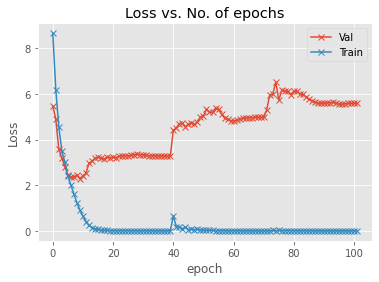

In [325]:
plot_loss(history)

In [ ]:
# torch.save(best_model, "./best_model.pt")

In [ ]:
torch.save(bests[0], 'drive/My Drive/Colab Notebooks/nlp-sadosky/model-lstm-v3.pt')

In [ ]:
# model.load_state_dict(best_model)

### Evaluate SimpleRNN

In [67]:
# !wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

--2020-07-03 20:03:08--  http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
Resolving dcc.uchile.cl (dcc.uchile.cl)... 192.80.24.11
Connecting to dcc.uchile.cl (dcc.uchile.cl)|192.80.24.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz [following]
--2020-07-03 20:03:08--  https://www.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
Resolving www.dcc.uchile.cl (www.dcc.uchile.cl)... 200.9.99.213, 192.80.24.11
Connecting to www.dcc.uchile.cl (www.dcc.uchile.cl)|200.9.99.213|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://users.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz [following]
--2020-07-03 20:03:09--  https://users.dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (u

In [68]:
# from gensim.models.keyedvectors import KeyedVectors
# wordvectors_file_vec = 'glove-sbwc.i25.vec.gz'
# cantidad = 100000
# wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [72]:
# embeddings = torch.FloatTensor(wordvectors.vectors)

In [413]:
class Config(object):
  embed_size = 300
  hidden_size = 2000
  output_size = data_trainable.Target.nunique()
  # max_epochs = 30
  # lr = 0.5
  # batch_size = 128

config = Config()

snn_model = SimpleNN(
  config=config, 
  # word_embeddings = embeddings, 
  vocab_size=len(TWEET.vocab),
)

snn_model.to('cuda')

SimpleNN(
  (embeddings): Embedding(1233, 300)
  (fc): Sequential(
    (0): Dropout(p=0.8, inplace=False)
    (1): Linear(in_features=300, out_features=2000, bias=True)
    (2): Dropout(p=0.8, inplace=False)
    (3): Linear(in_features=2000, out_features=53, bias=True)
  )
)

In [414]:
loss_fn = torch.nn.CrossEntropyLoss()

In [415]:
optimizer = torch.optim.AdamW(snn_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, verbose=True, min_lr=1e-6, factor=0.5)

In [416]:
history_nn = []

In [417]:
actual_history, best_model = fit(150, snn_model, train_iterator, valid_iterator, optimizer, loss_fn, scheduler, early_stopping=np.inf)
history_nn += actual_history

Epoch [1] || val_loss: 12.9259, val_acc: 0.0305 || train_loss : 12.9145, train_acc: 0.0288 || Last LR: 0.0100000
*************************
Epoch [2] || val_loss: 13.0645, val_acc: 0.0188 || train_loss : 18.1692, train_acc: 0.0225 || Last LR: 0.0100000
*************************
Epoch [3] || val_loss: 10.3141, val_acc: 0.0449 || train_loss : 15.9676, train_acc: 0.0342 || Last LR: 0.0100000
*************************
Epoch [4] || val_loss: 8.6227, val_acc: 0.0352 || train_loss : 16.3744, train_acc: 0.0222 || Last LR: 0.0100000
*************************
Epoch [5] || val_loss: 6.3318, val_acc: 0.0816 || train_loss : 14.3087, train_acc: 0.0331 || Last LR: 0.0100000
*************************
Epoch [6] || val_loss: 6.4331, val_acc: 0.0375 || train_loss : 13.7432, train_acc: 0.0280 || Last LR: 0.0100000
*************************
Epoch [7] || val_loss: 6.6919, val_acc: 0.0344 || train_loss : 13.0176, train_acc: 0.0433 || Last LR: 0.0100000
*************************
Epoch [8] || val_loss: 5.3403, 

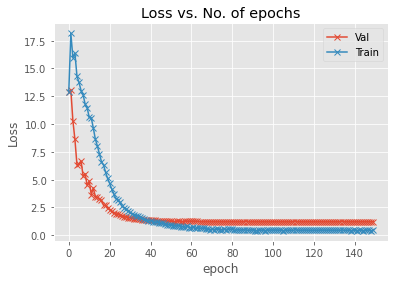

In [418]:
plot_loss(history_nn)

In [419]:
torch.save(best_model, 'drive/My Drive/Colab Notebooks/nlp-sadosky/model-simplenn.pt')

In [420]:
snn_model.load_state_dict(best_model)

<All keys matched successfully>

In [421]:
for i in train_iterator:
  print(i.Pregunta[:,0], i.Target[0], LABEL.vocab.itos[i.Target[0].item()])
  break

tensor([216,  57,   9,  23, 162,   2,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1], device='cuda:0') tensor(41, device='cuda:0') Cat_292


### [Remove this]Evaluate LogisticRegressor for low cardinality data

In [125]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import balanced_accuracy_score


In [376]:
data_low = data[data.Target.isin(categories)]


data_low_train, data_low_test = train_test_split(data_low, train_size=0.1, stratify=data_low.Target, shuffle=True, random_state=42)
data_low_valid, data_low_test = train_test_split(data_low_test, stratify=data_low_test.Target, train_size=0.1, shuffle=True)

In [387]:

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=10000)),
    # ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=50, tol=None))
])

parameters = {
    'vect__ngram_range': [(1, 2)],
    'tfidf__use_idf': (True, False),
    # 'clf__alpha': (1e-2, 1e-3, 1e-4),
    'clf__C': (2,5,20,50),
}

gs_clf = GridSearchCV(text_clf, parameters, cv=3, n_jobs=-1)

In [388]:
# text_clf.fit(data_low_train.Pregunta, data_low_train.Intencion)
gs_clf.fit(data_low_train.Pregunta, data_low_train.Intencion)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


KeyboardInterrupt: ignored

In [ ]:
gs_clf.best_params_

In [ ]:
print(balanced_accuracy_score(data_low_test.Intencion, gs_clf.best_estimator_.predict(data_low_test.Pregunta)))

### Evaluate results in test data


In [775]:
# acc = []
# for batch in test_iterator:
#   with torch.no_grad():
#     outputs = snn_model(batch.Pregunta)
#     acc.append(accuracy(outputs, batch.Target).numpy())


In [423]:
# print("Test performance: {:2f} +/- {:2f}".format(np.array(acc).mean(), np.array(acc).std()))

### Semi-Production (?)
Test our model  with input text.


In [424]:
def classify_tweet(tweet, TWEET, LABEL):
  processed = TWEET.process([TWEET.preprocess(tweet)])
  # print(processed)
  processed = processed.to('cuda')
  with torch.no_grad():
    return LABEL.vocab.itos[snn_model(processed).argmax().item()]

In [425]:
#@title ### Test the model!
text = "credito" #@param {type:"string"}
classify_tweet(text, TWEET, LABEL)

'Cat_225'

## Predictions
> *From deep learning with pytorch: Another hassle of torchtext is that it’s a bit of a pain to get it to predict things.*

it's true, the best solution was to fix the lenght for training, and when we predict on test-data, it will be best accurate. Also, Bert and other BigModels use this technique (Bert use 512, we have use 64).

Issues: 
- training data has sentences with more than 64 characters. 
- test data has small sentences, so we should use a longer fixed lenght
  - this issue also happend in bert too... Workarounds?

In [204]:
examples_data = map_examples(data)
fulldata = torchtext.data.Dataset(examples_data, fields)
fulldata[0].Target

'Cat_102'

In [205]:
# Build a vocabulary
%%timeit
vocab_size = 20000
TWEET.build_vocab(fulldata, max_size = vocab_size)
LABEL.build_vocab(fulldata)

10 loops, best of 3: 115 ms per loop


In [206]:
fulldata_iterator = torchtext.data.BucketIterator(
  fulldata, 
  batch_size = 128, 
  device = 'cuda',
  shuffle=True,
  sort_key = lambda x: len(x.Pregunta),
  sort_within_batch = False
)

In [208]:
class Config(object):
  embed_size = 300
  hidden_size = 2000
  output_size = data.Target.nunique()
  # max_epochs = 30
  # lr = 0.5
  # batch_size = 128

config = Config()

snn_model = SimpleNN(
  config=config, 
  # word_embeddings = embeddings, 
  vocab_size=len(TWEET.vocab),
)

snn_model.to('cuda')

SimpleNN(
  (embeddings): Embedding(5343, 300)
  (fc): Sequential(
    (0): Dropout(p=0.8, inplace=False)
    (1): Linear(in_features=300, out_features=2000, bias=True)
    (2): Dropout(p=0.8, inplace=False)
    (3): Linear(in_features=2000, out_features=352, bias=True)
  )
)

In [209]:
loss_fn = torch.nn.CrossEntropyLoss()

In [274]:
optimizer = torch.optim.AdamW(snn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, verbose=True, min_lr=1e-5, factor=0.5)

In [275]:
history_final = []

In [276]:
actual_history, best_model = fit(150, snn_model, fulldata_iterator, fulldata_iterator, optimizer, loss_fn, scheduler, early_stopping=np.inf)
history_final += actual_history

Epoch [1] || val_loss: 0.0574, val_acc: 0.9827 || train_loss : 0.2757, train_acc: 0.9140 || Last LR: 0.0010000
*************************
Epoch [2] || val_loss: 0.0575, val_acc: 0.9829 || train_loss : 0.2678, train_acc: 0.9161 || Last LR: 0.0010000
*************************
Epoch [3] || val_loss: 0.0583, val_acc: 0.9829 || train_loss : 0.2829, train_acc: 0.9136 || Last LR: 0.0010000
*************************
Epoch [4] || val_loss: 0.0568, val_acc: 0.9832 || train_loss : 0.2762, train_acc: 0.9148 || Last LR: 0.0010000
*************************
Epoch [5] || val_loss: 0.0594, val_acc: 0.9816 || train_loss : 0.2703, train_acc: 0.9144 || Last LR: 0.0010000
*************************
Epoch [6] || val_loss: 0.0577, val_acc: 0.9832 || train_loss : 0.2722, train_acc: 0.9161 || Last LR: 0.0010000
*************************
Epoch [7] || val_loss: 0.0593, val_acc: 0.9821 || train_loss : 0.2898, train_acc: 0.9106 || Last LR: 0.0010000
*************************
Epoch [8] || val_loss: 0.0577, val_acc: 0

In [277]:
torch.save(best_model, 'drive/My Drive/Colab Notebooks/nlp-sadosky/model-snn-full.pt')

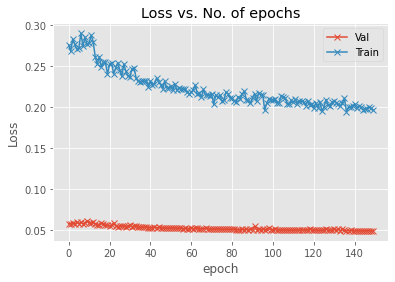

In [278]:
plot_loss(history_final)


In [279]:
df_test = pd.read_csv(TEST_DATA)
df_test

,id,Pregunta
0,0,querer saber tarjeta sin limite
1,1,¿cuál es el límite de mi tarjeta santander?
2,2,hay beneficios en restaurantes de la costa atl...
3,3,semana realizar pagar afip monotributo volver ...
4,4,por un prestamo de mil cuanto es el interes?
...,...,...
6697,6697,denunciar un cobro de tarjeta de credito
6698,6698,quiero pagar deuda refinanciada
6699,6699,quiero pagar de mi open credit un poquito mas ...
6700,6700,nesecito imprimir mi resumen tarjeta de credit...


In [280]:
df_test_ = df_test.copy()
df_test_ = df_test_.drop(columns="id")

In [281]:
cleaner = Cleaner()
pbar = tqdm(total=len(df_test_.Pregunta))
df_test_["Pregunta"] = df_test_.Pregunta.apply(lambda s: tqdemizado(s, pbar))
pbar.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [282]:
df_test_["Target"] = 1

In [283]:
to_predict = torchtext.data.Dataset(map_examples(df_test_), fields)

In [286]:
snn_model.load_state_dict(best_model)

<All keys matched successfully>

In [288]:
def pred_text(text, printtext = False):
  processed = TWEET.process([TWEET.preprocess(text)])
  if printtext:
    print(processed)
  processed = processed.to('cuda')
  snn_model.eval()
  with torch.no_grad():
    return LABEL.vocab.itos[snn_model(processed).argmax().item()]
  

In [289]:
df_test_.Target = df_test_.Pregunta.apply(pred_text)

In [290]:
df_test_.Target

0       Cat_303
1       Cat_303
2       Cat_311
3       Cat_129
4       Cat_258
         ...   
6697    Cat_112
6698    Cat_192
6699    Cat_199
6700    Cat_138
6701    Cat_337
Name: Target, Length: 6702, dtype: object

In [291]:
data["Predicted"] = data.Pregunta.apply(pred_text)

In [292]:
# data[data.Target == 19].Pregunta.apply(partial(pred_text, printtext=True))
data[data.Target == "Cat_19"]

,Pregunta,Intencion,Target,Predicted
88,buenos dias,Cat_19,Cat_19,Cat_19
302,buenas noches,Cat_19,Cat_19,Cat_19
3515,hola buen dia,Cat_19,Cat_19,Cat_19
7747,polis,Cat_19,Cat_19,Cat_19
14373,buenas tardes,Cat_19,Cat_19,Cat_19
18700,buen dia,Cat_19,Cat_19,Cat_19
19129,hola,Cat_19,Cat_19,Cat_19
19933,hola buenas tardes,Cat_19,Cat_19,Cat_19


In [293]:
balanced_accuracy_score(data.Intencion, data.Predicted)

0.9830089545640658

In [298]:
targets_dificiles = data[data.Intencion != data.Predicted].Target
data[data.Intencion.isin(targets_dificiles)].Target.value_counts()

Cat_132    600
Cat_293    567
Cat_1      493
Cat_147    488
Cat_223    477
          ... 
Cat_344      9
Cat_204      7
Cat_12       6
Cat_23       5
Cat_14       5
Name: Target, Length: 102, dtype: int64

### Save & submit solution

In [299]:
tosave = df_test.join(df_test_.drop(columns='Pregunta'))[['id', 'Target']]
tosave['Target'] = tosave["Target"].str.replace('Cat_','')
                                                         

In [300]:
tosave.to_csv('answers_snn.csv', header=False, index=False)

In [885]:
LABEL.process([0]), LABEL.vocab.stoi[0], LABEL.vocab.itos[87] # itos[answer] returns real labels mapped.

(tensor([87]), 87, 0)

In [879]:
TWEET.process([TWEET.preprocess(fulldata.examples[18700].Pregunta)]) # 2 is a <eos> and 1 is <pad>. 

tensor([[2233],
        [ 121],
        [   2],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        